In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

In [59]:
#Define the number of elememts in each set I, J, K
i_num = 18
k_num = 1
j_num = 120 #Without I and K, so real j_num_real = j_num + i_num + k_num

#Define empty data frames
I = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
J = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])
K = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longtitude'])


In [60]:
#Define sets of I, J, K, where J contains I and K

for i in range(i_num):
    I.loc[i, 'Point number'] = 'i'+ str(i)
    I.loc[i, 'Latitude'] = round(random.uniform(0, 100), 4)
    I.loc[i, 'Longtitude'] = round(random.uniform(0, 100), 4)

I.index = I['Point number']
    
    
for k in range(k_num):
    K.loc[k, 'Point number'] = 'k'+ str(k)
    K.loc[k, 'Latitude'] = round(random.uniform(0, 100), 4)
    K.loc[k, 'Longtitude'] = round(random.uniform(0, 100), 4)

K.index = K['Point number']


for j in range(j_num):
    J.loc[j, 'Point number'] = 'j'+ str(j)
    J.loc[j, 'Latitude'] = round(random.uniform(0, 100), 4)
    J.loc[j, 'Longtitude'] = round(random.uniform(0, 100), 4)

J.index = J['Point number'] 
J = pd.concat([J, K, I], axis = 0) #Include K to J
I.index

Index(['i0', 'i1', 'i2', 'i3', 'i4', 'i5', 'i6', 'i7', 'i8', 'i9', 'i10',
       'i11', 'i12', 'i13', 'i14', 'i15', 'i16', 'i17'],
      dtype='object', name='Point number')

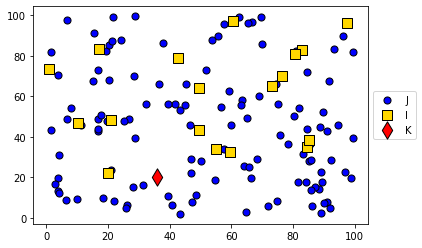

In [61]:
plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [62]:
#Define constants

B = 100
S = 20
alpha = 10

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400
    else:
        beta[j] = 400
        
q_j = {j: 50 for j in J.index}
up_bound = 10
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

mu

{'i0': 1,
 'i1': 8,
 'i2': 8,
 'i3': 10,
 'i4': 10,
 'i5': 9,
 'i6': 9,
 'i7': 8,
 'i8': 5,
 'i9': 8,
 'i10': 8,
 'i11': 0,
 'i12': 4,
 'i13': 5,
 'i14': 1,
 'i15': 8,
 'i16': 1,
 'i17': 2}

Deterministic model

In [63]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 2,
 'i1': 8,
 'i2': 8,
 'i3': 12,
 'i4': 16,
 'i5': 12,
 'i6': 7,
 'i7': 10,
 'i8': 4,
 'i9': 14,
 'i10': 1,
 'i11': 0,
 'i12': 6,
 'i13': 4,
 'i14': 0,
 'i15': 9,
 'i16': 1,
 'i17': 2}

In [64]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longtitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longtitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 28.281946308201633,
 ('k0', 'j1'): 49.9963382368149,
 ('k0', 'j2'): 50.69814074796037,
 ('k0', 'j3'): 29.613976687537253,
 ('k0', 'j4'): 62.91618720567863,
 ('k0', 'j5'): 45.6527816677144,
 ('k0', 'j6'): 33.422853226647184,
 ('k0', 'j7'): 52.59431897277499,
 ('k0', 'j8'): 56.52480169739652,
 ('k0', 'j9'): 30.628330947833255,
 ('k0', 'j10'): 40.92142111535228,
 ('k0', 'j11'): 15.005683451612594,
 ('k0', 'j12'): 53.774396998199805,
 ('k0', 'j13'): 15.49772307953655,
 ('k0', 'j14'): 45.619780328493476,
 ('k0', 'j15'): 51.939739854566085,
 ('k0', 'j16'): 46.86643452728189,
 ('k0', 'j17'): 10.261960144144002,
 ('k0', 'j18'): 20.298311316954422,
 ('k0', 'j19'): 83.43141320300165,
 ('k0', 'j20'): 59.5592270878325,
 ('k0', 'j21'): 11.408926936833277,
 ('k0', 'j22'): 28.852148192638964,
 ('k0', 'j23'): 32.88060240628204,
 ('k0', 'j24'): 85.71814297364357,
 ('k0', 'j25'): 82.38503546621801,
 ('k0', 'j26'): 82.81730629777812,
 ('k0', 'j27'): 58.47392520311938,
 ('k0', 'j28'): 29.41

In [65]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j3'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j42'),
 ('k0', 'j45'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j56'),
 ('k0', 'j58'),
 ('k0', 'j64'),
 ('k0', 'j70'),
 ('k0', 'j71'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j78'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j82'),
 ('k0', 'j83'),
 ('k0', 'j84'),
 ('k0', 'j85'),
 ('k0', 'j86'),
 ('k0', 'j87'),
 ('k0', 'j89'),
 ('k0', 'j92'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j96'),
 ('k0', 'j98'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j105'),
 ('k0', 'j107'),
 ('k0', 'j108'),
 ('k0', 'j111'),
 ('k0', 'j114'),
 ('k0', 'j115'),
 ('k0'

In [66]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j3'),
 ('k0', 'j6'),
 ('k0', 'j9'),
 ('k0', 'j11'),
 ('k0', 'j14'),
 ('k0', 'j18'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j42'),
 ('k0', 'j45'),
 ('k0', 'j51'),
 ('k0', 'j53'),
 ('k0', 'j58'),
 ('k0', 'j70'),
 ('k0', 'j73'),
 ('k0', 'j74'),
 ('k0', 'j79'),
 ('k0', 'j80'),
 ('k0', 'j81'),
 ('k0', 'j83'),
 ('k0', 'j84'),
 ('k0', 'j85'),
 ('k0', 'j86'),
 ('k0', 'j87'),
 ('k0', 'j89'),
 ('k0', 'j93'),
 ('k0', 'j94'),
 ('k0', 'j98'),
 ('k0', 'j103'),
 ('k0', 'j104'),
 ('k0', 'j105'),
 ('k0', 'j107'),
 ('k0', 'j108'),
 ('k0', 'j111'),
 ('k0', 'j114'),
 ('k0', 'j115'),
 ('k0', 'k0'),
 ('k0', 'i1'),
 ('k0', 'i2'),
 ('k0', 'i6'),
 ('k0', 'i11'),
 ('k0', 'i15'),
 ('k0', 'i16'),
 ('k0', 'i17')]

In [67]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [68]:
model_det = gp.Model('Deterministic model')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [69]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c6')

{('k0', 'j3', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j18', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j18', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j18', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j28', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j28', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j53', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j53', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j83', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j83', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j84', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j84', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j86', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j86', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j87', 'i17'): <gurobi.Constr *Awaiting Mo

In [70]:
model_det.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)

In [71]:
model_det.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 119 rows, 1417 columns and 312 nonzeros
Model fingerprint: 0x6b85fc32
Variable types: 0 continuous, 1417 integer (139 binary)
Coefficient statistics:
  Matrix range     [1e+00, 9e+01]
  Objective range  [1e+01, 4e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+02]
Found heuristic solution: objective 1950.0000000
Presolve removed 85 rows and 1340 columns
Presolve time: 0.01s
Presolved: 34 rows, 77 columns, 123 nonzeros
Variable types: 0 continuous, 77 integer (31 binary)

Root relaxation: objective 1.150000e+03, 48 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0   

In [72]:
def ListSolution(model):
        nSolutions = model_det.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model_det.setParam(GRB.Param.SolutionNumber, e)
                print('%g ' % model_det.PoolObjVal, end='\n')
                for v in model_det.getVars():
                        if v.xn > 0:
                                print ('%s %g' % (v.varName, v.Xn))
                print("\n")
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 2
1150 
x_ikj[i1,k0,j31] 8
x_ikj[i2,k0,j18] 8
x_ikj[i6,k0,j18] 7
x_ikj[i15,k0,j31] 9
x_ikj[i16,k0,j31] 1
x_ikj[i17,k0,j18] 2
y_j[j18] 1
y_j[j31] 1


1950 
x_ikj[i1,k0,j31] 8
x_ikj[i2,k0,j6] 8
x_ikj[i6,k0,i6] 7
x_ikj[i15,k0,j31] 9
x_ikj[i16,k0,j31] 1
x_ikj[i17,k0,j108] 2
y_j[j6] 1
y_j[j31] 1
y_j[j108] 1
y_j[i6] 1






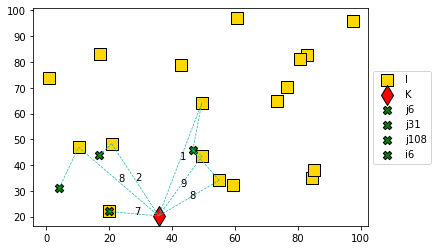

In [73]:
def SolutionGraph(I, K, J, model):
    
    # plt.scatter(J['Latitude'], J['Longtitude'], color = 'blue', edgecolors = 'black',
    #             marker = 'o', s = 30, label = 'J')
    plt.scatter(I['Latitude'], I['Longtitude'], color = 'gold', edgecolors = 'black',
                marker = 's', s = 150, label = 'I')
    plt.scatter(K['Latitude'], K['Longtitude'], color = 'red', edgecolors = 'black',
                marker = 'd', s = 200, label = 'K')
    for v in model.getVars():
        if v.xn > 0:
            if v.varName.startswith('x_ikj'):
                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                plt.plot((J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                        (J.loc[indices_x[2], 'Longtitude'], I.loc[indices_x[0], 'Longtitude']),
                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                plt.plot((I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                        (I.loc[indices_x[0], 'Longtitude'], K.loc[indices_x[1], 'Longtitude']),
                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                plt.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2,
                                                (K.loc[indices_x[1], 'Longtitude'] + I.loc[indices_x[0], 'Longtitude'])/2))
            else:
                index_y = v.varName[4:-1]
                plt.scatter(J.loc[index_y, 'Latitude'], J.loc[index_y, 'Longtitude'], color = 'green',
                            edgecolors = 'black', s = 70, marker = 'X', label = index_y)
    plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

Probabilistic model

In [74]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.97

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))

g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = up_bound * 4

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [75]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [76]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i1', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i1', 19): <gurobi.Constr *Awaiting

In [77]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for i in M_kj[(k, j)]) <= q_j[j] * y_j[j] for (k, j) in KJ_feas), name = 'c17')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * y_j[j] <= B
                  for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c18')
model_prob.addConstrs((dist_JI[(j, i)] * y_j[j] <= S for (k, j) in N_i[i] for i in M_kj[(k, j)]), name = 'c19')

{('k0', 'j3', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j3', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j18', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j18', 'i6'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j18', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j28', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j28', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j53', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j53', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j83', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j83', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j84', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j84', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j86', 'i2'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j86', 'i17'): <gurobi.Constr *Awaiting Model Update*>,
 ('k0', 'j87', 'i17'): <gurobi.Constr *Awaiting Mo

In [78]:
model_prob.setObjective(alpha * gp.quicksum(x_ikj) + gp.quicksum(beta[j] * y_j[j] for j in J.index), GRB.MINIMIZE)
model_prob.optimize()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads



GurobiError: Model too large for size-limited license; visit https://www.gurobi.com/free-trial for a full license

In [ ]:
ListSolution(model_prob)

Number of solutions found: 2
1210 
x_ikj[i1,k0,j31] 10
x_ikj[i2,k0,j18] 8
x_ikj[i6,k0,j18] 8
x_ikj[i15,k0,j31] 11
x_ikj[i16,k0,j31] 1
x_ikj[i17,k0,j18] 3
y_j[j18] 1
y_j[j31] 1


2010 
x_ikj[i1,k0,j31] 10
x_ikj[i2,k0,j6] 8
x_ikj[i6,k0,i6] 8
x_ikj[i15,k0,j31] 11
x_ikj[i16,k0,j31] 1
x_ikj[i17,k0,j108] 3
y_j[j6] 1
y_j[j31] 1
y_j[j108] 1
y_j[i6] 1






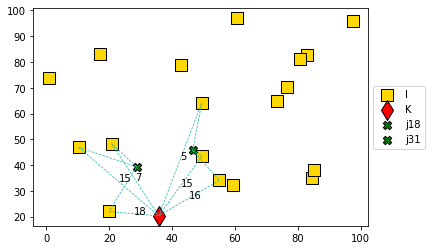

In [ ]:
SolutionGraph(I, K, J, model_prob)

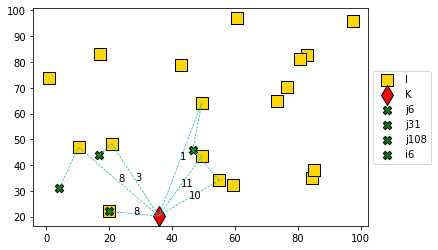

In [ ]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty